# **Projet 8 - Déployez un modèle dans le cloud : Notebook test local**

**Table des matières**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
  - 1.1. [Contexte](#toc1_1_)    
  - 1.2. [Mission](#toc1_2_)    
  - 1.3. [Contraintes](#toc1_3_)    
- 2. [Installation des librairies](#toc2_)    
- 3. [Définition des PATH pour charger les images et enregistrer les résultats](#toc3_)    
- 4. [Création de la SparkSession](#toc4_)    
- 5. [Traitement des données](#toc5_)    
  - 5.1. [Chargement des données](#toc5_1_)    
  - 5.2. [Préparation du modèle](#toc5_2_)    
    - 5.2.1. [Fonction pour la création du modèle](#toc5_2_1_)    
  - 5.3. [Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF](#toc5_3_)    
- 6. [Exécution des actions d'extraction de features](#toc6_)    
  - 6.1. [Application aux images du dossier img_test_local](#toc6_1_)    
  - 6.2. [Réduction dimensionnelle](#toc6_2_)    
  - 6.3. [Enregistrement des données](#toc6_3_)    
- 7. [Validation des résultats](#toc7_)    
  - 7.1. [Chargement des données](#toc7_1_)    
  - 7.2. [Création d'un colonne par composante](#toc7_2_)    
  - 7.3. [Sauvegarde des résultats](#toc7_3_)    
- 8. [Conclusion :](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)
### 1.1. <a id='toc1_1_'></a>[Contexte](#toc0_)
Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.  

Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.  

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

### 1.2. <a id='toc1_2_'></a>[Mission](#toc0_)
Vous êtes donc chargé de vous approprier les travaux réalisés par l’alternant et de compléter la chaîne de traitement.

Il n’est pas nécessaire d’entraîner un modèle pour le moment.

L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

### 1.3. <a id='toc1_3_'></a>[Contraintes](#toc0_)

Lors de son brief initial, Paul vous a averti des points suivants :
- Vous devrez tenir compte dans vos développements du fait que le volume de données va augmenter très rapidement après la livraison de ce projet. Vous continuerez donc à développer des scripts en Pyspark et à utiliser le cloud AWS pour profiter d’une architecture Big Data (EMR, S3, IAM). Si vous préférez, vous pourrez transférer les traitements dans un environnement Databricks

- Vous devez faire une démonstration de la mise en place d’une instance EMR opérationnelle, ainsi qu’ expliquer pas à pas le script PySpark, que vous aurez complété : 
    - d’un traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle) qui avait été oublié par l’alternant. Vous pourrez vous appuyer sur l’article “Distributed model inference using TensorFlow Keras” disponible dans les ressources
    - d’une étape de réduction de dimension de type PCA en PySpark 
    
- Vous respecterez les contraintes du RGPD : dans notre contexte, vous veillerez à paramétrer votre installation afin d’utiliser des serveurs situés sur le territoire européen 

- Votre retour critique de cette solution sera également précieuse, avant de décider de la généraliser

- La mise en œuvre d’une architecture Big Data de type EMR engendrera des coûts. Vous veillerez donc à ne maintenir l’instance EMR opérationnelle que pour les tests et les démos.

## 2. <a id='toc2_'></a>[Installation des librairies](#toc0_)

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
from typing import Iterator

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import img_to_array
from keras import Model

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
from pyspark.sql.types import ArrayType, FloatType

## 3. <a id='toc3_'></a>[Définition des PATH pour charger les images et enregistrer les résultats](#toc0_)

Dans cette version locale, nous n'utiliserons qu'un échantillon de 316 images réparties sur 2 fruits : 
- Apple Pink Lady : 152 images 
- Apple Red 1 : 164 images

Stockage des images dans le dossier : '1. Données/img_test_local'  
Résultats enregistrés dans le dossier : '2. Sauvegardes/Resultat_test_local'

In [3]:
# Création des chemins : 

path_data = '1. Données/img_test_local'
path_result = '2. Sauvegardes/Resultat_test_local'

## 4. <a id='toc4_'></a>[Création de la SparkSession](#toc0_)

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**.  
Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

Spécifications de la Spark Session : 
- Nom pour l'application affichée dans l'interface utilisateur: Web Spark "P8"
- Exécution de l'application en local
- Option de configuration supplémentaire permettant d'utiliser le format "parquet"
- Création d'une session spark si aucune n'existe

In [4]:
# Création de la SparkSession : 
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

24/01/02 17:43:17 WARN Utils: Your hostname, MacBook-Pro-14.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en0)
24/01/02 17:43:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/02 17:43:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Création de la variable "sc" (SparkContext) issue de la variable spark : 
sc = spark.sparkContext

In [6]:
# Affichage des informations de Spark en cours d'execution : 
spark

## 5. <a id='toc5_'></a>[Traitement des données](#toc0_)
### 5.1. <a id='toc5_1_'></a>[Chargement des données](#toc0_)

In [7]:
# Chargement des images avec l'extension .jpg sous format binaire présentes dans les répertoire path_data :
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path_data)

<u>Affichage des 5 premières images contenant</u>:
- Le path de l'image
- La date et l'heure de sa dernière modification
- Sa longueur
- Son contenu encodé en valeur hexadécimal

<u>Nous ne conserverons que le **path** et ajouterons une colonne contenant les **labels** de chaque image.<u>

In [8]:
# Ajout d'une nouvelle colonne 'label' au dataframe images : 
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# Affichage des résultats (5 premières lignes sans toncature) : 
images.select('path','label').show(5,False)

# Impression du schéma du dataframe : 
print(images.printSchema())

+----------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|path                                                                                                                                          |label      |
+----------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|file:/Users/maxime/Formation Data Scientist /Projets /8 - Deployez un modele dans le cloud/1. Données/img_test_local/Apple Red 1/r_325_100.jpg|Apple Red 1|
|file:/Users/maxime/Formation Data Scientist /Projets /8 - Deployez un modele dans le cloud/1. Données/img_test_local/Apple Red 1/r_326_100.jpg|Apple Red 1|
|file:/Users/maxime/Formation Data Scientist /Projets /8 - Deployez un modele dans le cloud/1. Données/img_test_local/Apple Red 1/r_327_100.jpg|Apple Red 1|
|file:/Users/maxime/Formation Data Scientist /Projets /8 -

### 5.2. <a id='toc5_2_'></a>[Préparation du modèle](#toc0_)

Pour l'extraction de features, nous utiliserons ici la technique de **transfert learnings** en utilisant le modèle **MobileNetV2** pour sa rapidité d'éxécution vis à vis d'autres modèles.

La dernière couche du modèle, servant à classer les images selon 1000 catégories, ne sera pas utilisée ici. L'idée est de récupérer le **vecteur de caractéristiques de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise en incluant toutes ses couches, attend obligatoirement des images de dimension (224,224,3).  
Les images étant toutes de dimension (100,100,3), nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Etapes de réalisation dans l'odre</u> :
 1. Chargement du modèle **MobileNetV2** avec les poids **précalculés** issus d'**imagenet** et en spécifiant le format de nos images en entrée
 
 2. Création d'un nouveau modèle avec :
    - En entrée: l'entrée du modèle MobileNetV2
    - En sortie : l'avant dernière couche du modèle MobileNetV2

In [9]:
# Création du modèle de base : 
base_model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [10]:
# Création du modèle spécifique : 
model = Model(inputs=base_model.input,
              outputs=base_model.layers[-2].output)

In [11]:
# Affichage du résumé du modèle : 
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │     864 │ input_layer[0][0]    │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │     128 │ Conv1[0][0]          │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │       0 │ bn_Conv1[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │     288 │ Conv1_relu[0][0]     │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │     128 │ expanded_conv_depth… │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │       0 │ expanded_conv_depth… │
│ (ReLU)              │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │     512 │ expanded_conv_depth… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │      64 │ expanded_conv_proje… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand      │ (None, 112, 112,  │   1,536 │ expanded_conv_proje… │
│ (Conv2D)            │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │     384 │ block_1_expand[0][0] │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │       0 │ block_1_expand_BN[0… │
│ (ReLU)              │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_pad         │ (None, 113, 113,  │       0 │ block_1_expand_relu… │
│ (ZeroPadding2D)     │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │     864 │ block_1_pad[0][0]    │
│ (DepthwiseConv2D)   │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │     384 │ block_1_depthwise[0… │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │       0 │ block_1_depthwise_B… │
│ (ReLU)              │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block_1_project     │ (None, 56, 56,    │   2,304 │ block_1_depthwise_r

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids.  
Une bonne pratique consiste donc à charger le modèle sur le driver puis à diffuser ensuite les poids aux différents workeurs.

In [12]:
# diffusion des poids du modèle à tous les noeuds du cluster Spark : 
brodcast_weights = sc.broadcast(model.get_weights())

#### 5.2.1. <a id='toc5_2_1_'></a>[Fonction pour la création du modèle](#toc0_)

In [13]:
def model_fn():
    """
    Charge et configure un modèle pré-entraîné MobileNetV2 pour l'extraction de caractéristiques.

    Returns:
        Model: Un modèle Keras configuré pour l'extraction de caractéristiques.
    """
    
    # Chargement du modèle MobileNetV2 pré-entraîné sur ImageNet :
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Désactivation de l'entraînement des couches existantes du modèle : 
    for layer in model.layers:
        layer.trainable = False
        
    # Création d'un nouveau modèle basé sur les caractéristiques du modèle existant : 
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)
    
    # Initialisation des poids du nouveau modèle avec les poids diffusés (broadcasted) : 
    new_model.set_weights(brodcast_weights.value)
    
    return new_model


### 5.3. <a id='toc5_3_'></a>[Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF](#toc0_)

L'empilement des appels est la suivante :
- Pandas UDF
  - Featuriser une série d'images pd.Series
    - Prétraitement d'une image

In [14]:
# Fonction de préparation des images : 
def preprocess(content):
    """
    Prétraite le contenu brut d'une image pour la prédiction.

    Args:
        content (bytes): Contenu brut de l'image au format bytes.

    Returns:
        numpy.ndarray: Tableau NumPy représentant l'image prétraitée.
    """
    
    # Ouverture de l'image à partir du contenu brut et la redimensionne : 
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Convertion de l'image en tableau NumPy : 
    arr = img_to_array(img)
    
    # Application du prétraitement spécifique au modèle : 
    return preprocess_input(arr)

In [15]:
# Fonction de création de features : 
def featurize_series(model, content_series):
    """
    Génère des caractéristiques (features) à partir d'une série d'images brutes en utilisant le modèle spécifié.

    Args:
        model (keras.Model): Modèle Keras utilisé pour générer les caractéristiques.
        content_series (pandas.Series): Série Pandas contenant du contenu brut d'images.

    Returns:
        pandas.Series: Série Pandas contenant les caractéristiques générées à partir des images.
    """
    # Prétraitement de chaque image dans la série : 
    input = np.stack(content_series.map(preprocess))
    
    # Préditction des caractéristiques : 
    preds = model.predict(input)
    
    # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
    # Nous aplatissions les tenseurs de caractéristiques en vecteurs pour un stockage plus facile dans les DataFrames Spark.
    output = [p.flatten() for p in preds]
    
    # Renvoir des caractéristiques sous forme de série Pandas : 
    return pd.Series(output)

In [16]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """
    Génère des caractéristiques à partir d'un itérateur sur des lots de données d'images en utilisant un modèle pré-chargé.

    Args:
        content_series_iter (Iterator[pandas.Series]): Un itérateur sur des lots de données, où chaque lot
                                                      est une série Pandas de données d'image.

    Yields:
        pandas.Series: Une série Pandas contenant les caractéristiques générées pour chaque lot d'images.
    """
    
    # Avec les Pandas UDF de type Scalar Iterator, nous pouvons charger le modèle une fois et le réutiliser
    # pour plusieurs lots de données. Cela amortit les frais généraux de chargement de gros modèles.
   
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_8_ocr-hiVB9eyE-py3.10/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## 6. <a id='toc6_'></a>[Exécution des actions d'extraction de features](#toc0_)
### 6.1. <a id='toc6_1_'></a>[Application aux images du dossier img_test_local](#toc0_)

Extraction des features pour les 316 images sur nos deux fruits : Apple Pink Lady (152 images) et Apple Red 1 (164 images) 

In [17]:
# Extraction des features en utilisant 20 exécuteurs : 
features_df = images.repartition(20).select(
    col("path"),
    col("label"),
    featurize_udf("content").alias("features")
)

# Visualisation de 5 lignes au hasard du DataFrame obte
features_df.sample(False, 0.1, seed=42).limit(5).show(truncate=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step 1) / 4]


+--------------------+---------------+--------------------+
|                path|          label|            features|
+--------------------+---------------+--------------------+
|file:/Users/maxim...|    Apple Red 1|[0.25895154, 0.0,...|
|file:/Users/maxim...|Apple Pink Lady|[0.7154877, 0.0, ...|
|file:/Users/maxim...|Apple Pink Lady|[0.08387601, 0.02...|
|file:/Users/maxim...|    Apple Red 1|[0.03417152, 0.0,...|
|file:/Users/maxim...|    Apple Red 1|[0.026569989, 0.0...|
+--------------------+---------------+--------------------+



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


### 6.2. <a id='toc6_2_'></a>[Réduction dimensionnelle](#toc0_)

Ici, nous appliquerons une PCA pour réduire les dimensions des features de chaque image.  
Le but étant d'atteindre au moins 95% de la variance expliquée. 

In [18]:
# Affichage du schéma du DataFrame : 
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



La colonne features étant de type array, nous aurons besoin pour cette étape de la transformer en type vecteur.

In [19]:
# Création d'une fonction de conversion de la colonne 'features' en vecteur : 
features_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Application de la fonction au DataFrame et création d'une nouvelle colonne : 
features_df = features_df.withColumn("features_vector", features_to_vector_udf("features"))

# Création du modèle PCA : 
pca = PCA(k=300, inputCol="features_vector", outputCol="pca_features")

# Application de la PCA au DataFrame : 
pca = pca.fit(features_df)
result_df = pca.transform(features_df)

# Calcul de la variance expliquée : 
explained_variances = pca.explainedVariance
cumulative_variances = np.cumsum(explained_variances)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━

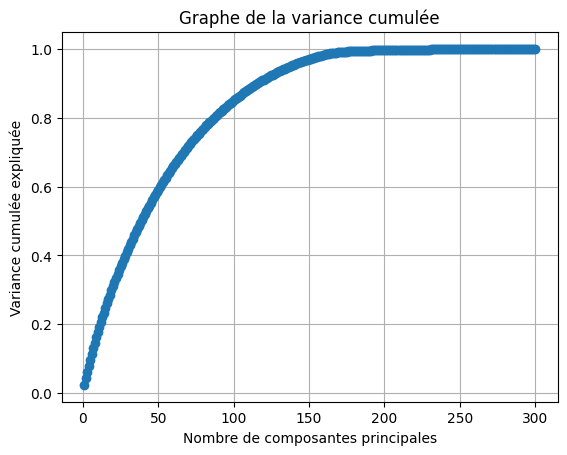

Nombre de composantes pour expliquer 95% de la variance : 138


In [20]:
# Affichage du graphique : 
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance cumulée expliquée')
plt.title('Graphe de la variance cumulée')
plt.grid(True)
plt.show()

# Détermination du nombre de composantes nécessaires pour expliquer 95% de la variance :
required_components = np.argmax(cumulative_variances >= 0.95) + 1
print(f"Nombre de composantes pour expliquer 95% de la variance : {required_components}")

Nous utiliserons donc ici une PCA avec 138 composantes. 

In [21]:
# Création d'un modèle PCA avec les 138 composantes principales pour atteindre 95% de la variance : 
pca = PCA(k=138, inputCol="features_vector", outputCol="vectorized_components_pca_features")

# Application de la PCA sur le DataFrame : 
pca = pca.fit(features_df)
features_df = pca.transform(features_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step1) / 20]
1/1 ━━━━━━━━━

In [22]:
# Affichage des 5 premières lignes : 
features_df.show(5, truncate=True)

24/01/02 17:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1436.7 KiB


+--------------------+-----------+--------------------+--------------------+----------------------------------+
|                path|      label|            features|     features_vector|vectorized_components_pca_features|
+--------------------+-----------+--------------------+--------------------+----------------------------------+
|file:/Users/maxim...|Apple Red 1|[0.9788739, 0.0, ...|[0.97887390851974...|              [-1.9755673385521...|
|file:/Users/maxim...|Apple Red 1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|              [7.72896921450518...|
|file:/Users/maxim...|Apple Red 1|[0.04550019, 0.0,...|[0.04550018906593...|              [8.80954791737265...|
|file:/Users/maxim...|Apple Red 1|[0.007542328, 0.0...|[0.00754232797771...|              [6.37712843918843...|
|file:/Users/maxim...|Apple Red 1|[0.1443576, 0.044...|[0.14435760676860...|              [5.51444239678931...|
+--------------------+-----------+--------------------+--------------------+----------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


In [23]:
# Restructuration des vecteurs composantes PCA en array : 

# Fonction de conversion vector to array : 
vector_to_array_udf = udf(lambda vec: vec.toArray().tolist(), ArrayType(FloatType()))

# Application de la fonction pour créer une nouvelle colonne pca_features : 
features_df = features_df.withColumn("pca_features", vector_to_array_udf("vectorized_components_pca_features"))

# Création du DataFrame final : 
final_df = features_df.select("path", "label", "pca_features")
final_df.show(5)
final_df.printSchema()

24/01/02 17:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1444.6 KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step 1) / 1]


+--------------------+-----------+--------------------+
|                path|      label|        pca_features|
+--------------------+-----------+--------------------+
|file:/Users/maxim...|Apple Red 1|[-1.9755673, 0.28...|
|file:/Users/maxim...|Apple Red 1|[7.728969, 0.2872...|
|file:/Users/maxim...|Apple Red 1|[8.809548, 0.3762...|
|file:/Users/maxim...|Apple Red 1|[6.3771286, 0.246...|
|file:/Users/maxim...|Apple Red 1|[5.5144424, 0.213...|
+--------------------+-----------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pca_features: array (nullable = true)
 |    |-- element: float (containsNull = true)



### 6.3. <a id='toc6_3_'></a>[Enregistrement des données](#toc0_)
Nous enregistrerons les données au format parquet. 

In [24]:
# Enregistrement des données : 
final_df.write.mode("overwrite").parquet(path_result)

print(f'Données enregistrées dans : {path_result}')

24/01/02 17:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1639.7 KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step1) / 20]


Données enregistrées dans : 2. Sauvegardes/Resultat_test_local


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


## 7. <a id='toc7_'></a>[Validation des résultats](#toc0_)
### 7.1. <a id='toc7_1_'></a>[Chargement des données](#toc0_)

In [25]:
# Chargement des données depuis path_result : 
df = pd.read_parquet(path_result, engine='pyarrow')

print(f'Dimension de df : {df.shape}')
df.head()

Dimension de df : (316, 3)


,path,label,pca_features
0,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,"[-1.9755673, 0.28277263, 0.6187498, 0.23784609..."
1,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,"[7.728969, 0.287217, 0.9276988, -0.10701924, -..."
2,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,"[8.809548, 0.37622792, 0.40250984, 0.30939704,..."
3,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,"[6.3771286, 0.24603304, 1.2709584, 0.1715672, ..."
4,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,"[5.5144424, 0.2133194, 0.8348614, 0.41482896, ..."


In [26]:
# Validation de la dimension des pca_features : 
print(f"Dimension des pca_features : {df.loc[0, 'pca_features'].shape}")

Dimension des pca_features : (138,)


### 7.2. <a id='toc7_2_'></a>[Création d'un colonne par composante](#toc0_)

In [27]:
columns = []
nbr_composantes = 138

# Récupération des series de composates : 
for i in range(nbr_composantes): 
    columns.append(pd.Series(df['pca_features'].apply(lambda x: x[i]), name=f'pca_feature_{i+1}'))

# Concaténation des colonnes au DataFrame df : 
df = pd.concat([df] + columns, axis=1)

# Suppression de pca_features : 
df = df.drop('pca_features', axis=1)

# Affichage : 
print(f"Dimension de df : {df.shape}")
df.head()

Dimension de df : (316, 140)


,path,label,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4,pca_feature_5,pca_feature_6,pca_feature_7,pca_feature_8,...,pca_feature_129,pca_feature_130,pca_feature_131,pca_feature_132,pca_feature_133,pca_feature_134,pca_feature_135,pca_feature_136,pca_feature_137,pca_feature_138
0,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,-1.975567,0.282773,0.618750,0.237846,-0.180705,9.234996,-0.253098,1.107731,...,0.749315,-2.812196,0.092006,0.424097,-0.916154,-0.085394,-0.431176,-0.079384,-0.589983,0.237196
1,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,7.728969,0.287217,0.927699,-0.107019,-0.010708,0.453251,-0.000244,1.106560,...,0.296275,-0.073829,-0.178512,0.538381,-1.220596,0.148388,-0.606221,0.023306,-0.483193,0.292953
2,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,8.809548,0.376228,0.402510,0.309397,0.169291,1.197730,0.135358,1.109782,...,0.523778,-0.392930,0.065499,0.272224,-1.044034,-0.063375,-0.237956,-0.193698,-0.489685,0.279775
3,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,6.377129,0.246033,1.270958,0.171567,-0.157822,3.750591,-0.034238,1.488019,...,0.475686,-4.528523,0.154074,0.506486,-0.885563,-0.066487,-0.446508,0.029894,-0.399068,0.265554
4,file:/Users/maxime/Formation Data Scientist /P...,Apple Red 1,5.514442,0.213319,0.834861,0.414829,-0.161342,6.937006,0.069573,0.998651,...,0.744299,-0.860129,0.079624,0.436447,-0.834876,0.096509,-0.509830,-0.002959,-0.344308,0.344073


In [28]:
# Répartition par labels : 
df['label'].value_counts()

label
Apple Red 1        164
Apple Pink Lady    152
Name: count, dtype: int64

Nous retrouvons bien la répartition de nos labels avec pour chaque image les composantes PCA de celles-ci. 

### 7.3. <a id='toc7_3_'></a>[Sauvegarde des résultats](#toc0_)
Sauvegarde du DataFrame au format CSV

In [29]:
# Enregistrement du DataFrame en tant que fichier CSV : 
df.to_csv('2. Sauvegardes/df_results_local.csv', index=False)

## 8. <a id='toc8_'></a>[Conclusion :](#toc0_)

Nous pouvons considéré le processus comme validé, en local sur le jeu de données allégés.  

Nous avons simulé, pour celui-ci,  un cluster de machines en répartissant la charge de travail sur différents cœurs de processeur au sein d'une même machine.